Project 2: LSTMs for Language Detection
=============

### Murali Raghu Babu Balusu, Audrija Mukherjee
- GaTech id: 903241955 , 903225854
- GaTech username: mbalusu3, amukherjee44
- Email: b.murali@gatech.edu   (or)   muraliraghubabu1994@gmail.com; 
	 amukherjee44@gatech.edu 
- Phone: 470-338-1473, 404-910-9919

Part 1 of this blog explains implementation of how to build string scoring models and then combine them into a single language detector. In Part 2, we explore extensions and possible improvements to the model(s). The languages used are English and French.

Part - I
============

Importing all required libraries and methods

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score, make_scorer
import sklearn
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop, SGD, Adamax, Adadelta
from keras.utils.data_utils import get_file
from keras.callbacks import EarlyStopping
import keras
import numpy as np
import random
import sys

Using TensorFlow backend.


Reading the data in from English and French data files

In [6]:
fname1 = './data/eng.txt'
fname2 = './data/frn.txt'
with open(fname1) as f:
    content1 = f.read().lower()
with open(fname2) as f:
    content2 = f.read().lower()

Creating the English train, test content

In [7]:
tr_eng = int(len(content1)*0.8)
train_eng = content1[:tr_eng]
test_eng_content = content1[tr_eng:]

Create the French train, test content

In [8]:
tr_frn = int(len(content2)*0.8)
train_frn = content2[:tr_frn]
test_frn_content = content2[tr_frn:]

Writing test set the test holdout files and reading them in

In [10]:
#write into holdout files
eng_file=open("eng_holdout.txt","w")
eng_file.write(test_eng_content)
eng_file.close()
frn_file=open("frn_holdout.txt","w")
frn_file.write(test_frn_content)
frn_file.close()
#Read from holdout file.
# **NOTE**: can be done directly without storing the holdout files but instructions specify to do so
with open("eng_holdout.txt") as f1:
    test_eng_content = f1.read()
with open("frn_holdout.txt") as f2:
    test_frn_content = f2.read()

Randomly selecting test substrings

In [11]:
#obtaining train and test words for both english and french.
test_indices1 = np.random.randint(0,len(test_eng_content)-45,100) 
test_engwords = [test_eng_content[i:i+45] for i in test_indices1]
len(train_eng),len(test_eng_content), len(test_engwords)

test_indices2 = np.random.randint(0,len(test_frn_content)-45,100)
test_frnwords = [ test_frn_content[i:i+45] for i in test_indices2]
len(train_frn),len(test_frn_content), len(test_frnwords)

(9591, 2398, 100)

**NOTE**- Above: Here we choose sequences of length 45. The last 5 charaters of each are used for calculating the probabilities. Explained below.

In [12]:
# Creating a combined character set from both english and french contents
text = train_eng
eng_chars = sorted(list(set(text)))
text = train_frn
frn_chars = sorted(list(set(text)))
all_chars = sorted(list(set(frn_chars + eng_chars+['*'])))
all_char_indices = dict((c, i) for i, c in enumerate(all_chars))

# English

Creating samples from the training data by cutting the text into maxlen length sequences. The sequences are chosen to have some redundancy decided by the step value. We use a step value of 1. Also we include sequences of length less than maxlan. Therefore, if the text is "Universal Declaration of Human Rights Preamble Whereas recognition" and maxlen=40, the training set has sequences- 'U', 'Uni', .....'Universal Declaration of Human Rights Pr','niversal Declaration of Human Rights Pre'..... 

In [73]:
text = train_eng
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 1
sentences = []
next_chars = []
#Here we take into consideration even the initial sequences having <40 length
for i in range(0,maxlen):
    s='*'
    for j in range(i):
        s+=text[j]
    sentences.append(s)
    next_chars.append(text[i])
for i in range(-maxlen, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))
#print (sentences)
#print (next_chars)

nb sequences: 8630


Vectorize the samples in the training set by simply filling a 1 in the right place according to the character set and keep a 0 everywhere else. X dimensions are (len(samples in train set) X maxlen X len(character set))

In [74]:
X_eng = np.zeros((len(sentences), maxlen, len(all_chars)), dtype=np.bool)
y_eng = np.zeros((len(sentences), len(all_chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    #print (sentence)
    for t, char in enumerate(sentence):
        #print (char)
        X_eng[i, t, all_char_indices[char]] = 1
    y_eng[i, all_char_indices[next_chars[i]]] = 1
print('Vectorization done')

Vectorization done


Building the model for English LSTM

In [75]:
# build the model: a single LSTM for English
eng_model = Sequential()
eng_model.add(LSTM(128, input_shape=(maxlen, len(all_chars))))
eng_model.add(Dense(len(all_chars)))
eng_model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
eng_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
print('English Model Built')

English Model Built


Train the English LSTM model. Parameters used are as specified in problem description, batch size=128, epochs=5

In [76]:
eng_model.fit(X_eng, y_eng,batch_size=128,epochs=5)

Epoch 1/5
8630/8630 [==============================] - 20s - loss: 2.7909     

# French

Do the exact same process to create the LSTM model for French. Create the train set, vectorise the samples in it. Then build and train the French LSTM model

In [77]:
text = train_frn
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 1
sentences = []
next_chars = []
for i in range(0,maxlen):
    s='*'
    for j in range(i):
        s+=text[j]
    sentences.append(s)
    next_chars.append(text[i])
for i in range(-maxlen, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))
#print (sentences)
#print (next_chars)

nb sequences: 9640


In [78]:
X_frn = np.zeros((len(sentences), maxlen, len(all_chars)), dtype=np.bool)
y_frn = np.zeros((len(sentences), len(all_chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    #print (sentence)
    for t, char in enumerate(sentence):
        #print (char)
        X_frn[i, t, all_char_indices[char]] = 1
    y_frn[i, all_char_indices[next_chars[i]]] = 1
print('Vectorization done')

Vectorization done


In [79]:
# build the model: a single LSTM for French
frn_model = Sequential()
frn_model.add(LSTM(128, input_shape=(maxlen, len(all_chars))))
frn_model.add(Dense(len(all_chars)))
frn_model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
frn_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
print('French model built')

French model built


In [80]:
frn_model.fit(X_frn, y_frn,batch_size=128,epochs=5)

Epoch 1/5
9640/9640 [==============================] - 39s - loss: 2.8278      

# Get Log probability of word

This function takes a 45(maxlen+5) length "word" as input, vectorizes the word one character at a time. The first 40 are not used in the test probability calculation. For the last 5 characters, we use the previous 40 characters' vector and calculate the probability of getting each character in the character set. We take the probability of the character that actually occurs next to calculate the log probability as mentioned in the problem description. 

**NOTE** We used the previous 40 characters for each 5 character test sequence since it gave better results. Intuitively also it makes sense because using context of the previous characters to generate a next ones should produce better results.

In [81]:
def get_logprobability_word(model, word):
    generated = ''
    sentence=word[:maxlen]
    log_prob=0
    for i in range(5):  #predicting probability of next 5 characters
            x = np.zeros((1, maxlen, len(all_char_indices)))
            for t, char in enumerate(sentence):
                x[0, t, all_char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            next_char = word[maxlen+i]
            log_prob+=(np.log(preds[all_char_indices[next_char]]))
            #generated += next_char
            sentence = sentence[1:] + next_char

    return log_prob

Create the test labels and the entire test samples sequences with English and French samples

In [82]:
test_words = test_engwords+test_frnwords
test_labels = [1]*len(test_engwords) + [0]*len(test_frnwords)

Getting log probablity of each test word

In [29]:
eng_logprobs = [ get_logprobability_word(eng_model,word) for word in test_words]
frn_logprobs = [ get_logprobability_word(frn_model,word) for word in test_words]
print ("Calculated log probabilities")

Calculated log probabilities


Calculate y_hat=(log(Pr(string|eng) - log(Pr(string|frn)). Using difference because it seems to work better here.

In [30]:
#calculating y_hat values
#using y_hat=(log(Pr(string|eng) - log(Pr(string|frn)) because it seems to work better here
pred_labels = [float(eng_logprobs[i])-float(frn_logprobs[i]) \
               for i in range(len(eng_logprobs))]  #y_hat

Plotting the ROC curve

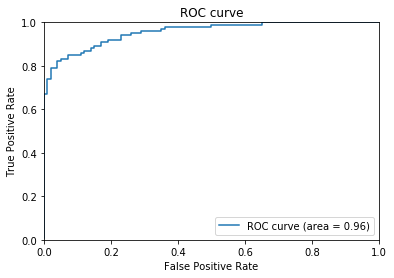

In [31]:
fpr, tpr, thresholds = roc_curve(list(test_labels), list(pred_labels))
roc_auc = auc(fpr, tpr)
#plt.figure()
plt.plot(fpr,tpr,label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

## The ROC AUC obtained is 96% here.

### Using spaces instead of the original 40 characters. However, the previous model performs better than this.

In [16]:
def get_logprobability_word_space(model, word):
    generated = ''
    sentence=' '*40
    log_prob=0
    for i in range(5):  #predicting probability of next 5 characters
            x = np.zeros((1, maxlen, len(all_char_indices)))
            for t, char in enumerate(sentence):
                x[0, t, all_char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            next_char = word[maxlen+i]
            log_prob+=(np.log(preds[all_char_indices[next_char]]))
            #generated += next_char
            sentence = sentence[1:] + next_char

    return log_prob

In [17]:
test_words = test_engwords+test_frnwords
test_labels = [1]*len(test_engwords) + [0]*len(test_frnwords)

In [19]:
eng_logprobs = [ get_logprobability_word_space(eng_model,word) for word in test_words]
frn_logprobs = [ get_logprobability_word_space(frn_model,word) for word in test_words]
print ("Calculated log probabilities")

Calculated log probabilities


In [89]:
#calculating y_hat values
#using y_hat=(log(Pr(string|eng) - log(Pr(string|frn)) because it seems to work better here
pred_labels = [float(eng_logprobs[i])-float(frn_logprobs[i]) \
               for i in range(len(eng_logprobs))]  #y_hat

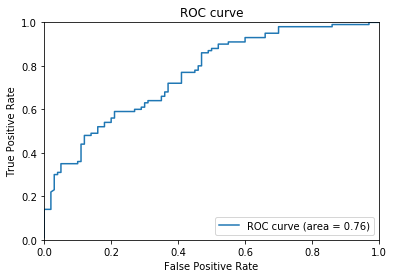

In [90]:
fpr, tpr, thresholds = roc_curve(list(test_labels), list(pred_labels))
roc_auc = auc(fpr, tpr)
#plt.figure()
plt.plot(fpr,tpr,label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

- Using spaces in place of the original 40 characters before the 5 char test substrings, deters the performance of the model. However, using the original 40 characters drastically improves the performance of the model as shown in the previous experiment and hence, we use the original 40 characters for all of the experiments from now on.

 # Answers to Part 1 Questions
 1. Is this model good? 
     - Yes, the above trained LSTM models are good enough to generate the next few characters given the previous characters. Using these trained LSTM models for calculating the log probability of the word and then to classify a string for language gives good results, as shown above. Clearly, since the test strings are taken from the same document itself, the model performs better. However, in order to make the model more generalizable, training the model with lots of english data and french data respectively would give even better results.
 
 2. What are at least three alternatives to language detection that you can think of or find on the internet? What are the pros and cons of each approach?
     - N-grams: N-grams of texts are extensively used in text mining and natural language processing tasks. They are basically a set of co-occuring words/characters within a given window. For example, in English, it's very common for the letter 'u' to follow the letter 'q,' while this is not the case in transliterated Arabic. n-grams work by capturing this structure. Thus, certain combinations of letters are more likely in some languages than others. This is the basis of n-gram classification. We can then use them as features and use different classifiers on top of them for classification. 
     Pros: 1) Works well in practice, 2) Easy to implement and understand, 3) can be easily extended to multiple languages.
     Cons: 1) You need large amounts of data for the model to generalize well to any type of texts, because the model's through construction itself depends a lot on the underlying character structure in the training dataset.
     
     - Bag of words: Construct features using words- unigrams, bigrams, trigrams as features and then use a classification technique to classify them based on language. It somewhat depends on searching through a large dictionary and essentially doing template matching. 
     Pros: 1) Easy to implement and intuitive, 2) Can be easily extended to multiple languages.
     Cons: 1) Each language would have to have an extensive dictionary of words on file, which would take a relatively long time to search through, and 2) bag-of-words will fail if none of the words in the training set are included in the testing set.
     
     - Embedding techniques: Using word2vec embedding, character embeddings as features and using deep convolution neural networks or other techniques like RNNs, LSTMs. GRU has been explored a lot for language detection recently.
     Pros: 1) It has shown to work well in real world and generalizes quite well even to unseen data.
     Cons: 1) Requires large training dataset for it to generalize well, 2) Tough to understand what is happening inside the model.

 3. Briefly describe at least 5 ways that you can improve this model, and what you think the value and predicted result of each approach would be? Example: “could use GPUs for training -> faster to get datasets; no change in efficacy”
     - Use Larger Datasets: Using larger datasets, would make the model more robust to language variation and give better results.
     - Use GPUs for training and make sure to use cross-validation to ensure that there is no overfitting in the model and for faster training.
     - Optimization Technique for LSTMs: Explore various optimization techniques here for training, Adamax works best here. Results shown below.
     - Vary the learning rate: The model in general is very sensitive to learning rate, so vary the learning rate accordingly. We got the best results using lr=0.01
     - Varying the no. of epochs: Increasing the no of epochs to a certain extent helps, but beyond that use cross validation/regularization to reduce the overfitting of the model.
     - Use other features: instead of just one-hot encoding characters as features for the LSTMs as done here, we can use other features like n-grams and even they work quite well in practice. Combining them as feature could also help for language detection experiments.
     

Part - II
============

# Extra Credit I: Experiments by varying parameters of the LSTM model

The following method defines the same procedure as above, of building the English and French LSTM model with the parameters like number of epochs, Activation function, the optimizer type and the loss function as input parameters. We will simply pass in different parameters and experiment to find which model gives a better ROC-AUC. The baseline model has n_epochs=5, activation function=softmax,optimizer type=RMS,loss=categorical_crossentropy.

In [36]:
def LSTM_experiments(n_epochs,activation,optimizer_name,loss):

    if optimizer_name=="RMS":
        optimizer = RMSprop(lr=0.01)
    elif optimizer_name=="SGD":
        optimizer =SGD(lr=0.01)
    elif optimizer_name=="Adamax":
        optimizer=Adamax(lr=0.01)
    elif optimizer_name=="Adadelta":
        optimizer=Adadelta(lr=0.01)
    else:
        print ("Invalid optimizer")
        return 0
    # build the model: English LSTM model
    print('Build English model...')
    eng_model = Sequential()
    eng_model.add(LSTM(128, input_shape=(maxlen, len(all_chars))))
    eng_model.add(Dense(len(all_chars)))
    eng_model.add(Activation(activation))
    eng_model.compile(loss=loss, optimizer=optimizer)
    eng_model.fit(X_eng, y_eng,batch_size=128,epochs=n_epochs,verbose=0)

    # build the model: French LSTM model
    print('Build French model...')
    frn_model = Sequential()
    frn_model.add(LSTM(128, input_shape=(maxlen, len(all_chars))))
    frn_model.add(Dense(len(all_chars)))
    frn_model.add(Activation(activation))

    optimizer = RMSprop(lr=0.01)
    frn_model.compile(loss=loss, optimizer=optimizer)
    frn_model.fit(X_frn, y_frn,batch_size=128,epochs=n_epochs,verbose=0)
    
    test_words = test_engwords+test_frnwords
    test_labels = [1]*len(test_engwords) + [0]*len(test_frnwords)
    #get log probabilities
    eng_logprobs = [ get_logprobability_word(eng_model,word) for word in test_words]
    frn_logprobs = [ get_logprobability_word(frn_model,word) for word in test_words]
    print ("Calculated log probabilities")

    #y-hat here
    pred_labels = [float(eng_logprobs[i])-float(frn_logprobs[i]) \
                   for i in range(len(eng_logprobs))]

    #plot the ROC curve
    fpr, tpr, thresholds = roc_curve(list(test_labels), list(pred_labels))
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr,label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

We vary the loss using mean squared error, cosine proximity and binary cross-entropy. Binary cross entropy works comparatively well, giving an ROC-AUC of about 94%. Cosine proximity doesn't seem to work very well here.

Varying the loss function

loss=mean_squared_error
Build English model...
Build French model...
Calculated log probabilities


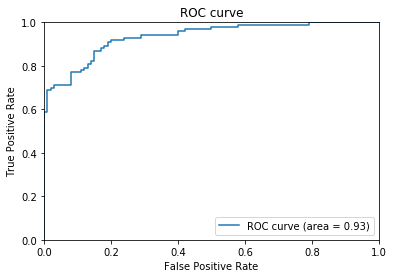

ROC-AUC= 0.9344

loss=cosine_proximity
Build English model...
Build French model...
Calculated log probabilities


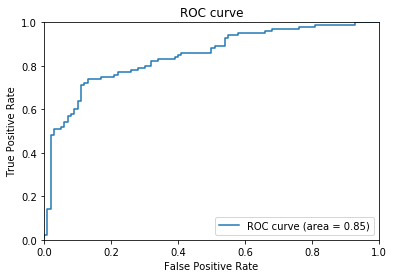

ROC-AUC= 0.8466

loss=binary_crossentropy
Build English model...
Build French model...
Calculated log probabilities


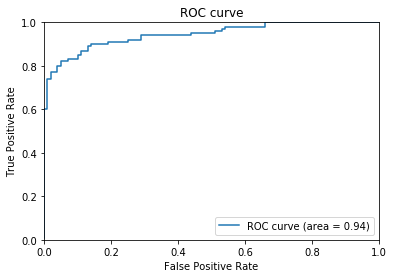

ROC-AUC= 0.9433


In [38]:
#varying the loss
print ("Varying the loss function")
#Baseline was this: print ("categorical_crossentropy", LSTM_experiments(5,'softmax',"RMS","categorical_crossentropy"))
print ("\nloss=mean_squared_error")
print ("ROC-AUC=",LSTM_experiments(5,'softmax',"RMS","mean_squared_error"))
print ("\nloss=cosine_proximity")
print ("ROC-AUC=", LSTM_experiments(5,'softmax',"RMS","cosine_proximity"))
print ("\nloss=binary_crossentropy")
print ("ROC-AUC=", LSTM_experiments(5,'softmax',"RMS","binary_crossentropy"))

We vary the optimizer using SGD, Adamax and Adadelta. Adamax performs at par with the baseline(RMS_prop) but SGD and Adadelta optimizer perform worse for this dataset.

Varying the optimizers

Optimizer=SGD
Build English model...
Build French model...
Calculated log probabilities


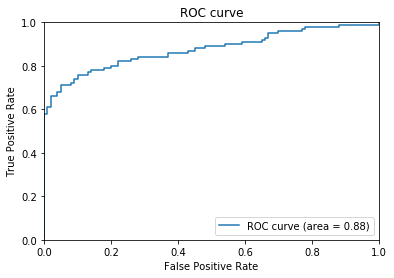

ROC-AUC= 0.8754

Optimizer=Adamax
Build English model...
Build French model...
Calculated log probabilities


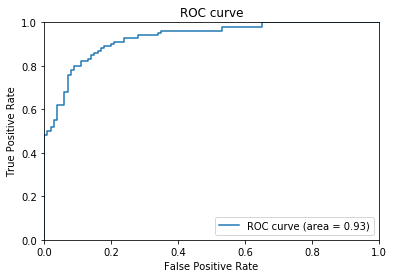

ROC-AUC= 0.928

Optimizer=Adadelta
Build English model...
Build French model...
Calculated log probabilities


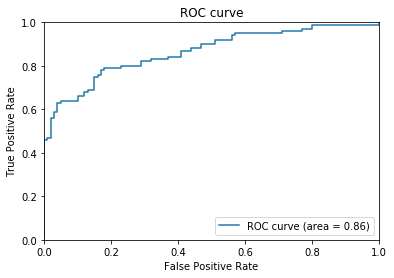

ROC-AUC= 0.8646


In [39]:
#varying the optimizers
print ("Varying the optimizers")
#Baseline was this: print ("categorical_crossentropy", LSTM_experiments(5,'softmax',"RMS","categorical_crossentropy"))
print ("\nOptimizer=SGD")
print ("ROC-AUC=", LSTM_experiments(5,'softmax',"SGD","categorical_crossentropy"))
print ("\nOptimizer=Adamax")
print ("ROC-AUC=", LSTM_experiments(5,'softmax',"Adamax","categorical_crossentropy"))
print ("\nOptimizer=Adadelta")
print ("ROC-AUC=", LSTM_experiments(5,'softmax',"Adadelta","categorical_crossentropy"))

We vary the activation function using relu, tanh and sigmoid. Relu and tanh give NaN/infinity values which is expected. The sigmoid activation function loss does not seem to work well for this dataset. It gives a lower ROC of about 75%, as compared to the 1st baseline model which gave ROC-AUC of 91%.

Varying the activation function

Activation = relu produces NaN/infinity
Activation = tanh produces NaN/infinity

Activation = sigmoid
Build English model...
Build French model...
Calculated log probabilities


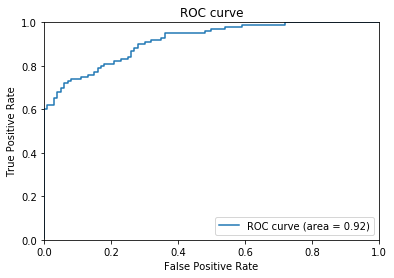

ROC-AUC= 0.9152


In [40]:
#varying the activation function
print ("Varying the activation function\n")
#Baseline was this: print ("categorical_crossentropy", LSTM_experiments(5,'softmax',"RMS","categorical_crossentropy"))
#relu produces NaN/infinity
print ("Activation = relu produces NaN/infinity")
#print ("ROC-AUC=", LSTM_experiments(5,'relu',"RMS","categorical_crossentropy"))
#tanh also produces NaN/infinity
print ("Activation = tanh produces NaN/infinity")
#print ("ROC-AUC=", LSTM_experiments(5,'tanh',"RMS","categorical_crossentropy"))
print ("\nActivation = sigmoid")
print ("ROC-AUC=", LSTM_experiments(5,'sigmoid',"RMS","categorical_crossentropy"))

We vary the number of epochs using 10,20,50. For number of epochs=10, the ROC-AUC is highest at 96%. However, as we increase the number of epochs beyond 10 the ROC-AUC decreases. This is probably due to the models being overfit to the training data.

Varying the number of epochs
Number of epochs=10
Build English model...
Build French model...
Calculated log probabilities


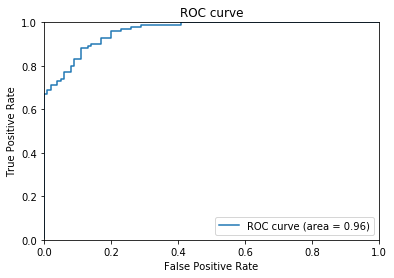

ROC-AUC= 0.96
Number of epochs=20
Build English model...
Build French model...
Calculated log probabilities


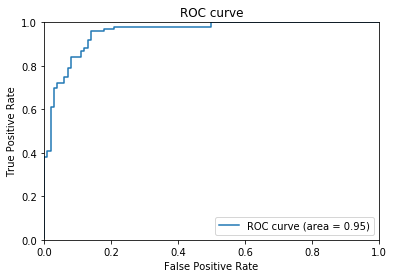

ROC-AUC= 0.9544
Number of epochs=50
Build English model...
Build French model...
Calculated log probabilities


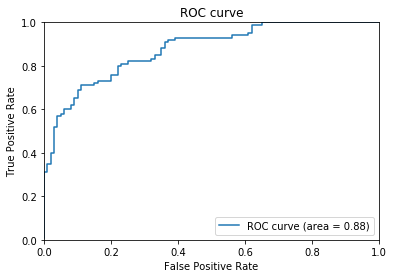

ROC-AUC= 0.8764


In [79]:
#varying the epochs
print ("Varying the number of epochs")
#Baseline was this: print ("categorical_crossentropy", LSTM_experiments(5,'softmax',"RMS","categorical_crossentropy"))
print ("Number of epochs=10")
print ("ROC-AUC=", LSTM_experiments(10,'softmax',"RMS","categorical_crossentropy"))
print ("Number of epochs=20")
print ("ROC-AUC=", LSTM_experiments(20,'softmax',"RMS","categorical_crossentropy"))
print ("Number of epochs=50")
print ("ROC-AUC=", LSTM_experiments(50,'softmax',"RMS","categorical_crossentropy"))

### **Summary of experiments on LSTM models**

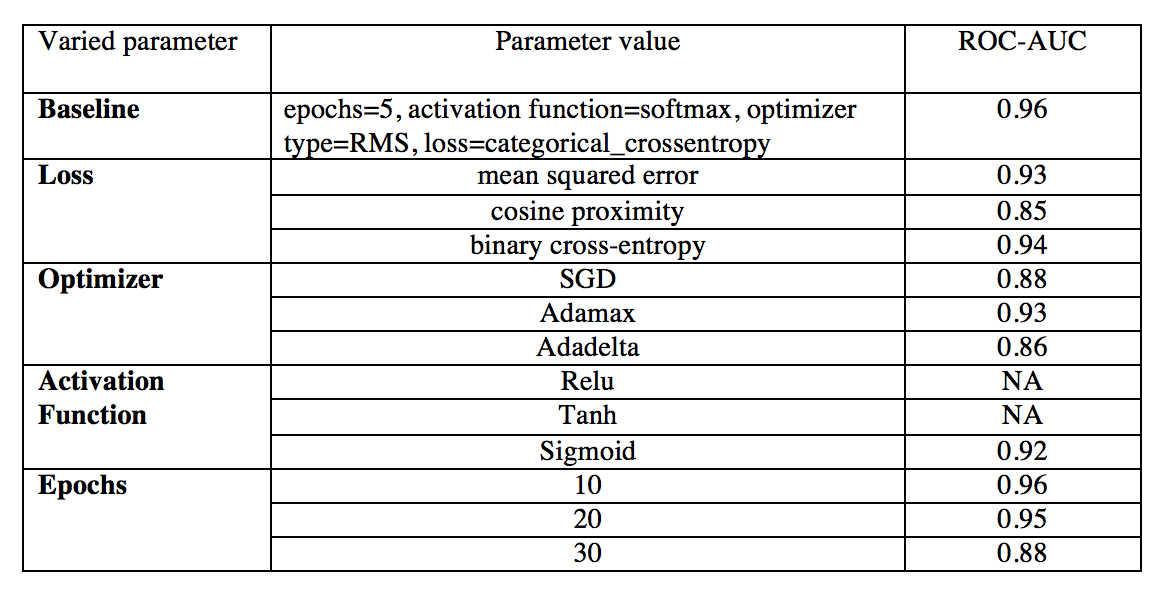

In [41]:
from IPython.display import Image
Image(filename='results.png')

# Extra Credit II: Exploring Early Stopping using Validation Technique
- Criterion for Early Stopping: Validation Loss, min improvement: 0.05, run for 1 epoch after no improvement and then quit if still no improvement is observed in val_loss
- I tried using other values as well, Increasing the min improvement would hurt the performance of the model, and decreasing it would reduce the effect of early stopping on the model. Hence, I used min_improvement=0.05. This provided a right balance between both of them.

In [26]:
#Using 20% of training data as validation data
train_eng = int(0.8*len(X_eng))
train_frn = int(0.8*len(X_frn))

Xtrain_eng = X_eng[0:train_eng]
Ytrain_eng = y_eng[0:train_eng]
Xval_eng = X_eng[train_eng:]
Yval_eng = y_eng[train_eng:]

Xtrain_frn = X_frn[0:train_frn]
Ytrain_frn = y_frn[0:train_frn]
Xval_frn = X_frn[train_frn:]
Yval_frn = y_frn[train_frn:]

In [41]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.05, patience=1, verbose=0, mode='auto')
# build the model: a single LSTM for English
eng_model2 = Sequential()
eng_model2.add(LSTM(128, input_shape=(maxlen, len(all_chars))))
eng_model2.add(Dense(len(all_chars)))
eng_model2.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
eng_model2.compile(loss='categorical_crossentropy', optimizer=optimizer)
print('English Model Built')

eng_model2.fit(Xtrain_eng, Ytrain_eng,batch_size=128,epochs=20,validation_data=(Xval_eng, Yval_eng),\
               callbacks=[early_stopping])

English Model Built
Train on 6904 samples, validate on 1726 samples
Epoch 1/20
6904/6904 [==============================] - 18s - loss: 2.9034 - val_loss: 2.7391

### The model stops by using early stopping criterion set in the code.

In [42]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.05, patience=1, verbose=0, mode='auto')
# build the model: a single LSTM for French
frn_model2 = Sequential()
frn_model2.add(LSTM(128, input_shape=(maxlen, len(all_chars))))
frn_model2.add(Dense(len(all_chars)))
frn_model2.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
frn_model2.compile(loss='categorical_crossentropy', optimizer=optimizer)
print('French model built')

frn_model2.fit(Xtrain_frn, Ytrain_frn,batch_size=128,epochs=20,validation_data=(Xval_frn, Yval_frn),\
              callbacks=[early_stopping])

French model built
Train on 7712 samples, validate on 1928 samples
Epoch 1/20
7712/7712 [==============================] - 17s - loss: 2.7661 - val_loss: 2.7251

In [60]:
test_words = test_engwords+test_frnwords
test_labels = [1]*len(test_engwords) + [0]*len(test_frnwords)

eng_logprobs = [ get_logprobability_word(eng_model2,word) for word in test_words]
frn_logprobs = [ get_logprobability_word(frn_model2,word) for word in test_words]
print ("Calculated log probabilities")
#calculating y_hat values
#using y_hat=(log(Pr(string|eng) - log(Pr(string|frn)) because it seems to work better here
pred_labels2 = [float(eng_logprobs[i])-float(frn_logprobs[i]) \
               for i in range(len(eng_logprobs))]  #y_hat

Calculated log probabilities


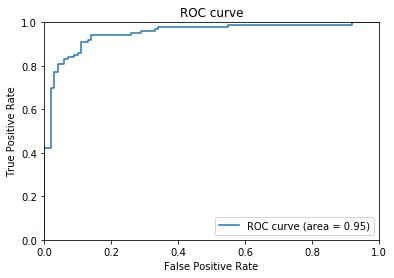

In [61]:
# Plotting the ROC curve
fpr, tpr, thresholds = roc_curve(list(test_labels), list(pred_labels2))
roc_auc = auc(fpr, tpr)
#plt.figure()
plt.plot(fpr,tpr,label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

- As shown above, Using early stopping on validation loss does not deter the performance of your model. The models still performs well and infact generalizes well now on unseen data. Early stopping is a well-known technique to avoid overfitting of the model when training a model iteratively.

# Extra credit III : Exploring N-grams

N-grams are contiguous sequences of n items from a given sequence of text or speech. As explained above, they are useful for language modelling because they successfully capture co-occurence of characters/words.

Here we use character level features rather than word level. This helps to identify the suffixes and prefixes which are generally language specific(Eg. -ing, ex-, dis-, etc in English). For the relatively small text that we use here for training, it seems like a good choice to include character level features.

The following block of code creates training samples from our 80% train data for both English and French. Then we take n-grams of length 1 to 5, vectorize them using tf-idf vectorizer and use those as features to train our Linear SVM model.

Language Detector using n-grams


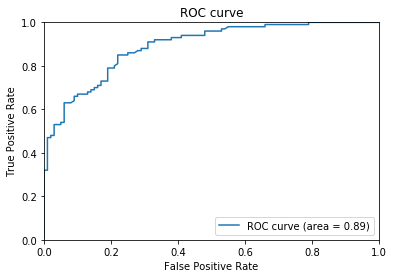

In [20]:
#import all libraries and methods required
from sklearn import ensemble
from sklearn import feature_extraction
from sklearn import svm
from sklearn import pipeline
from sklearn import cross_validation
from sklearn import metrics

print ("Language Detector using n-grams")

#create the train set by using maxlen number of charaters from English and French 80% train splits. 
#They form semi-redundant sequences for the training set

maxlen=40
step = 1

X_train_eng,X_train_frn=[],[]
for i in range(0, len(train_eng) - maxlen, step):
    X_train_eng.append(train_eng[i: i + maxlen])
for i in range(0, len(train_frn) - maxlen, step):
    X_train_frn.append(train_frn[i: i + maxlen])
X_train=X_train_eng+X_train_frn

#create the labels for train set, English-0, French-1
y_train=[1]*len(X_train_eng)+[0]*len(X_train_frn)

#we use n-grams of length 1 to 5, and use tfidf vectorizer to transform the train set
vectorizer = feature_extraction.text.TfidfVectorizer(ngram_range=(1, 5),analyzer='char',)

#we use linear SVC classifier
pipe = pipeline.Pipeline([('vectorizer', vectorizer),('clf', svm.SVC(kernel='linear', probability=True))])
pipe.fit(X_train, y_train)

#using the 5 charater sequences as test samples
test_words_new=[word[-5:] for word in test_words]

#predicting the probabilities for the test sequences
y_proba=pipe.predict_proba(test_words_new)

#plotting the ROC curve
fpr, tpr, thresholds = roc_curve(list(test_labels), list(y_proba[:,1]))
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

The ROC-AUC obtained from n-grams of length 1 to 5 is 89%. The model performs well on this dataset and we believe increasing the training corpus to include more samples will further improve the performance.

### That's it. The code is well documented throughout. Please get back to us if you have any further questions.
### Thank you.

References:
    1. https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py 
    2. http://colah.github.io/posts/2015-08-Understanding-LSTMs/
    3. http://karpathy.github.io/2015/05/21/rnn-effectiveness/
    4. https://keras.io/activations/, https://keras.io/losses/
    5. https://bugra.github.io/work/notes/2014-12-26/language-detector-via-scikit-learn/